# BCE GAN (Binary Cross-Entropy Loss)

100%|██████████| 170M/170M [00:03<00:00, 45.1MB/s]


Epoch [0/50] | D Loss: 0.6572 | G Loss: 3.5208
Epoch [1/50] | D Loss: 0.6699 | G Loss: 3.1640
Epoch [2/50] | D Loss: 0.2832 | G Loss: 2.1667
Epoch [3/50] | D Loss: 0.5840 | G Loss: 4.1970
Epoch [4/50] | D Loss: 0.2469 | G Loss: 3.1981
Epoch [5/50] | D Loss: 0.3243 | G Loss: 4.0317
Epoch [6/50] | D Loss: 0.3671 | G Loss: 3.4809
Epoch [7/50] | D Loss: 1.4968 | G Loss: 2.5537
Epoch [8/50] | D Loss: 0.1601 | G Loss: 3.3076
Epoch [9/50] | D Loss: 0.2120 | G Loss: 2.6728
Epoch [10/50] | D Loss: 0.3582 | G Loss: 2.4124
Epoch [11/50] | D Loss: 0.2348 | G Loss: 3.3836
Epoch [12/50] | D Loss: 0.1395 | G Loss: 3.4390
Epoch [13/50] | D Loss: 0.4392 | G Loss: 2.0248
Epoch [14/50] | D Loss: 0.2932 | G Loss: 4.9973
Epoch [15/50] | D Loss: 0.0808 | G Loss: 4.3757
Epoch [16/50] | D Loss: 0.4207 | G Loss: 6.3348
Epoch [17/50] | D Loss: 0.3148 | G Loss: 3.8759
Epoch [18/50] | D Loss: 0.1268 | G Loss: 4.7693
Epoch [19/50] | D Loss: 0.1217 | G Loss: 4.2216
Epoch [20/50] | D Loss: 0.3038 | G Loss: 4.8163
Ep

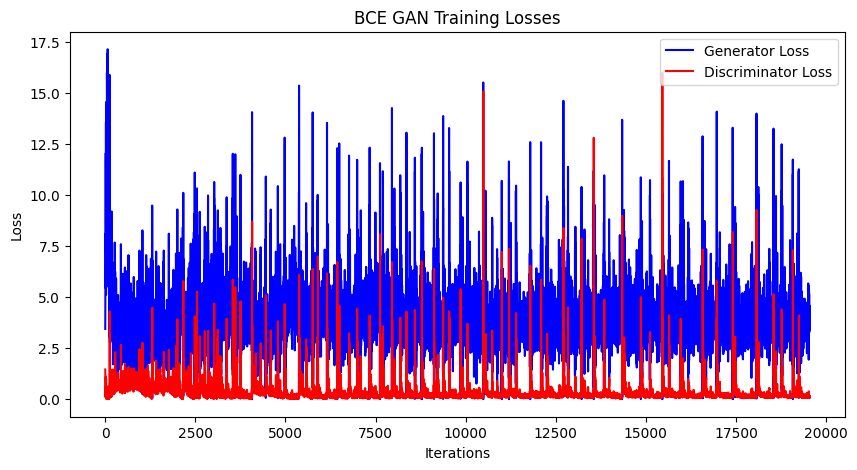

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hyperparameters
latent_dim = 100
batch_size = 128
epochs = 50
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
os.makedirs("images_bce", exist_ok=True)

# Dataset (CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

# Initialize models and optimizers
G = Generator().to(device)
D = Discriminator().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Training loop
G_losses = []
D_losses = []
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        D.zero_grad()
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Real images
        real_outputs = D(real_imgs)
        d_loss_real = criterion(real_outputs, real_labels)

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        fake_outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        G.zero_grad()
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

    # Save generated images
    if epoch % 5 == 0:
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        save_image(fake, f"images_bce/epoch_{epoch}.png", nrow=8, normalize=True)

    print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
sns.lineplot(data=G_losses, label="Generator Loss", color="blue")
sns.lineplot(data=D_losses, label="Discriminator Loss", color="red")
plt.title("BCE GAN Training Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("bce_loss.png")
plt.show()

# LS-GAN (Least Squares Loss)

Epoch [0/50] | D Loss: 0.1643 | G Loss: 1.4273
Epoch [1/50] | D Loss: 0.2701 | G Loss: 1.3276
Epoch [2/50] | D Loss: 0.4070 | G Loss: 0.6042
Epoch [3/50] | D Loss: 0.2464 | G Loss: 0.6566
Epoch [4/50] | D Loss: 0.1385 | G Loss: 0.9513
Epoch [5/50] | D Loss: 0.3582 | G Loss: 0.3412
Epoch [6/50] | D Loss: 0.1916 | G Loss: 1.0791
Epoch [7/50] | D Loss: 0.2125 | G Loss: 1.3616
Epoch [8/50] | D Loss: 0.1347 | G Loss: 1.0851
Epoch [9/50] | D Loss: 0.2648 | G Loss: 0.4453
Epoch [10/50] | D Loss: 0.2474 | G Loss: 0.3966
Epoch [11/50] | D Loss: 0.1742 | G Loss: 1.0821
Epoch [12/50] | D Loss: 0.1741 | G Loss: 0.6368
Epoch [13/50] | D Loss: 0.1100 | G Loss: 0.7290
Epoch [14/50] | D Loss: 0.1378 | G Loss: 1.2841
Epoch [15/50] | D Loss: 0.1671 | G Loss: 0.7083
Epoch [16/50] | D Loss: 0.1556 | G Loss: 0.7033
Epoch [17/50] | D Loss: 0.0787 | G Loss: 1.1877
Epoch [18/50] | D Loss: 0.3386 | G Loss: 1.3208
Epoch [19/50] | D Loss: 0.0594 | G Loss: 0.8107
Epoch [20/50] | D Loss: 0.2807 | G Loss: 0.2707
Ep

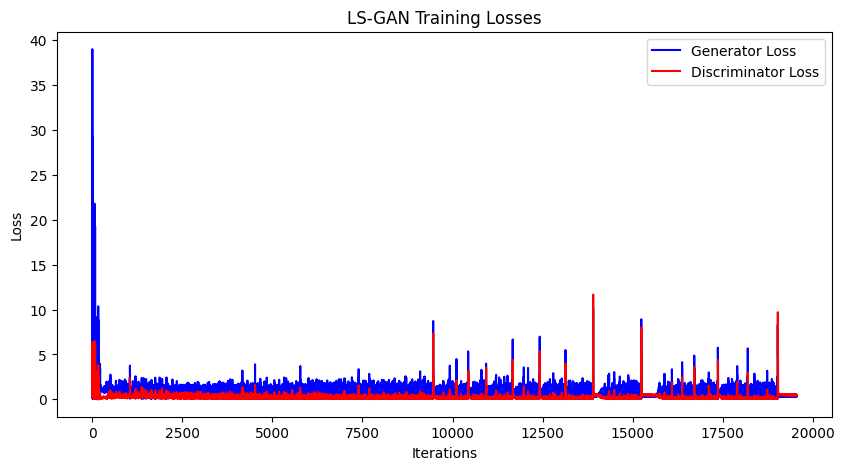

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hyperparameters
latent_dim = 100
batch_size = 128
epochs = 50
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
os.makedirs("images_lsgan", exist_ok=True)

# Dataset (CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator (LSGAN-specific: no sigmoid + MSE loss)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

# Initialize models and optimizers
G = Generator().to(device)
D = Discriminator().to(device)
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.MSELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Training loop
G_losses = []
D_losses = []
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        D.zero_grad()
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Real images
        real_outputs = D(real_imgs)
        d_loss_real = criterion(real_outputs, real_labels)

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        fake_outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        G.zero_grad()
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

    # Save generated images
    if epoch % 5 == 0:
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        save_image(fake, f"images_lsgan/epoch_{epoch}.png", nrow=8, normalize=True)

    print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
sns.lineplot(data=G_losses, label="Generator Loss", color="blue")
sns.lineplot(data=D_losses, label="Discriminator Loss", color="red")
plt.title("LS-GAN Training Losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("lsgan_loss.png")
plt.show()